<a href="https://colab.research.google.com/github/UTDataMining/2022A/blob/main/lab12/Intro_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 畳み込みニューラルネットワーク（CNN）の基礎

In [1]:
# グラフ可視化用
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

## CIFAR-10データセット
‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’の10クラスからなる画像認識のデータセット。

各画像は32x32ピクセルでRGBの3チャンネルからなる。

[The CIFAR dataset](https://www.cs.toronto.edu/~kriz/cifar.html)


![CIFAR-10](https://pytorch.org/tutorials/_images/cifar10.png)

In [3]:
# データセットの取得
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 各ピクセルを平均0.5,偏差0.5に標準化
])
train_set = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10('data', train=False, download=True, transform=transform)
print(len(train_set), len(test_set))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
50000 10000


In [4]:
# データローダー
batch_size = 200 # バッチサイズ
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

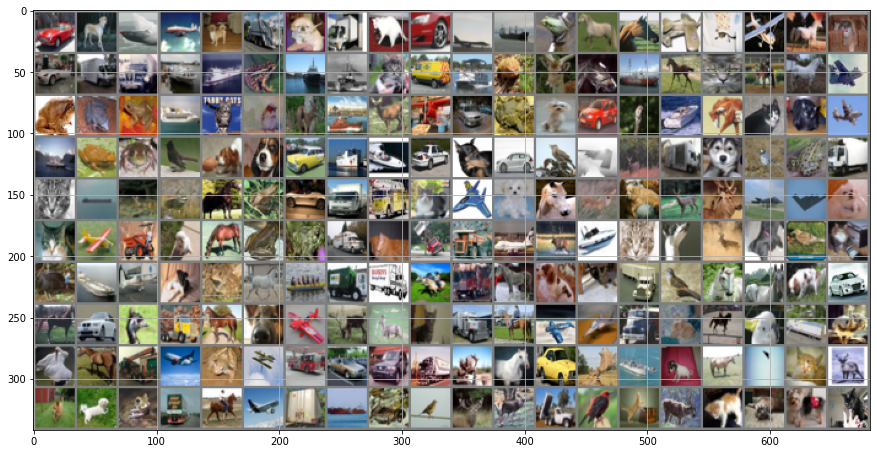

In [6]:
# データセット可視化
dataiter = iter(train_loader)
images, labels = next(dataiter)
viz = torchvision.utils.make_grid(images, nrow=20, padding = 2).numpy()
viz = 0.5*viz + 0.5 # 可視化用に標準化戻す
fig, ax = plt.subplots(figsize= (15,15))
ax.imshow(np.transpose(viz, (1,2,0)))
ax.grid(None)

## 単純な畳み込みニューラルネットワーク
畳み込み層+プーリング層+フルコネクト層からなる単純なネットワーク構成

畳み込み層
[CONV2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

プーリング層
[MAXPOOL2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

畳み込みやプーリングでは、paddingといって、出力サイズを調整するため入力の周囲をある値（典型的には0）で埋める処理を行うことがあります。

また、畳み込みやプーリングのフィルタを入力に適用していく間隔を指定するstrideを指定し、出力サイズを調整することがあります。

In [7]:
class Net_Simple(torch.nn.Module):
    def __init__(self):
        super(Net_Simple, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5) # 畳み込み層 (5x5)x6=150パラメータ
        self.pool1 = torch.nn.MaxPool2d(2, 2) # プーリング層 サイズ2, ストライド2
        self.fc1 = torch.nn.Linear(6*14*14, 50) # フルコネクト層 6x14x14x50=58800パラメータ
        self.fc2 = torch.nn.Linear(50, 10) # 出力層
        self.relu = torch.nn.ReLU() # 活性化関数
        
    def forward(self, x):
        x = self.relu(self.conv1(x)) # (32x32, 3channel) => (28x28, 6channel）
        x = self.pool1(x) # (28x28, 6channel) => (14x14, 6channel)
        x = x.view(x.shape[0], -1) # (14x14, 6channel） => 6x14x14（この1次元テンソルがバッチサイズx.shape[0]個ある） 
        x = self.relu(self.fc1(x)) # 6x14x14 => 50
        x = self.fc2(x) # 50 => 10
        return x

## LeNet-5
Y.LeCunらによって提案されたLeNet-5 [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)によるネットワーク構成

![LeNet](https://paperswithcode.com/media/methods/LeNet_Original_Image_48T74Lc.jpg)

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5) # 畳み込み層 (5x5)x6=150パラメータ
        self.pool1 = torch.nn.MaxPool2d(2, 2) # プーリング層 サイズ2, ストライド2
        self.conv2 = torch.nn.Conv2d(6, 16, 5) # 畳み込み層 (5x5)x16=400パラメータ
        self.pool2 = torch.nn.MaxPool2d(2, 2) # プーリング層 サイズ2, ストライド2
        self.fc1 = torch.nn.Linear(16*5*5, 120) # フルコネクト層 16x5x5x120=48000パラメータ
        self.fc2 = torch.nn.Linear(120, 84) # フルコネクト層 120x84=10080パラメータ
        self.fc3 = torch.nn.Linear(84, 10) # 出力層
        self.relu = torch.nn.ReLU() # 活性化関数
        
    def forward(self, x):
        x = self.relu(self.conv1(x)) # (32x32, 3channel) => (28x28, 6channel）
        x = self.pool1(x) # (28x28, 6channel) => (14x14, 6channel)
        x = self.relu(self.conv2(x)) # (14x14, 6channel) => (10x10, 16channel）
        x = self.pool2(x) # (10x10, 16channel) => (5x5, 16channel）
        x = x.view(x.shape[0], -1) # (5x5, 16channel） => 16x5x5（この1次元テンソルがバッチサイズx.shape[0]個ある） 
        x = self.relu(self.fc1(x)) # 16x5x5 => 120
        x = self.relu(self.fc2(x)) # 120 => 84
        x = self.fc3(x) # 84 => 10
        return x

## LeNet-5+ドロップアウト
ドロップアウト
[DROPOUT2D](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)

In [9]:
class Net_Dropout(torch.nn.Module):
    def __init__(self):
        super(Net_Dropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5) # 畳み込み層 (5x5)x6=150パラメータ
        self.pool1 = torch.nn.MaxPool2d(2, 2) # プーリング層 サイズ2, ストライド2
        self.dropout1 = torch.nn.Dropout2d(p=0.4)
        self.conv2 = torch.nn.Conv2d(6, 16, 5) # 畳み込み層 (5x5)x16=400パラメータ
        self.pool2 = torch.nn.MaxPool2d(2, 2) # プーリング層 サイズ2, ストライド2
        self.dropout2 = torch.nn.Dropout2d(p=0.4)
        self.fc1 = torch.nn.Linear(16*5*5, 120) # フルコネクト層 16x5x5x120=48000パラメータ
        self.fc2 = torch.nn.Linear(120, 84) # フルコネクト層 120x84=10080パラメータ
        self.fc3 = torch.nn.Linear(84, 10) # 出力層
        self.relu = torch.nn.ReLU() # 活性化関数
        
    def forward(self, x):
        x = self.relu(self.conv1(x)) # (32x32, 3channel) => (28x28, 6channel）
        x = self.pool1(x) # (28x28, 6channel) => (14x14, 6channel)
        x = self.dropout1(x)
        x = self.relu(self.conv2(x)) # (14x14, 6channel) => (10x10, 16channel）
        x = self.pool2(x) # (10x10, 16channel) => (5x5, 16channel）
        x = self.dropout2(x)
        x = x.view(x.shape[0], -1) # (5x5, 16channel） => 16x5x5（この1次元テンソルがバッチサイズx.shape[0]個ある） 
        x = self.relu(self.fc1(x)) # 16x5x5 => 120
        x = self.relu(self.fc2(x)) # 120 => 84
        x = self.fc3(x) # 84 => 10
        return x

## LeNet-5+バッチ正規化
バッチ正規化
[BATCHNORM2D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

In [10]:
class Net_BatchNorm(torch.nn.Module):
    def __init__(self):
        super(Net_BatchNorm, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5) # 畳み込み層 (5x5)x6=150パラメータ
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = torch.nn.MaxPool2d(2, 2) # プーリング層 サイズ2, ストライド2
        self.conv2 = torch.nn.Conv2d(6, 16, 5) # 畳み込み層 (5x5)x16=400パラメータ
        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = torch.nn.MaxPool2d(2, 2) # プーリング層 サイズ2, ストライド2
        self.fc1 = torch.nn.Linear(16*5*5, 120) # フルコネクト層 16x5x5x120=48000パラメータ
        self.fc2 = torch.nn.Linear(120, 84) # フルコネクト層 120x84=10080パラメータ
        self.fc3 = torch.nn.Linear(84, 10) # 出力層
        self.relu = torch.nn.ReLU() # 活性化関数
        
    def forward(self, x):
        x = self.batchnorm1(self.conv1(x))
        x = self.relu(x) # (32x32, 3channel) => (28x28, 6channel）        
        x = self.pool1(x) # (28x28, 6channel) => (14x14, 6channel)
        x = self.batchnorm2(self.conv2(x))
        x = self.relu(x) # (14x14, 6channel) => (10x10, 16channel）
        x = self.pool2(x) # (10x10, 16channel) => (5x5, 16channel）
        x = x.view(x.shape[0], -1) # (5x5, 16channel） => 16x5x5（この1次元テンソルがバッチサイズx.shape[0]個ある） 
        x = self.relu(self.fc1(x)) # 16x5x5 => 120
        x = self.relu(self.fc2(x)) # 120 => 84
        x = self.fc3(x) # 84 => 10
        return x

In [11]:
print(Net())

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


## モデルの学習
実行の前にメニューの

ランタイム -> ランタイムのタイプの変更　

でハードウェアアクセラレータをGPUにしてください

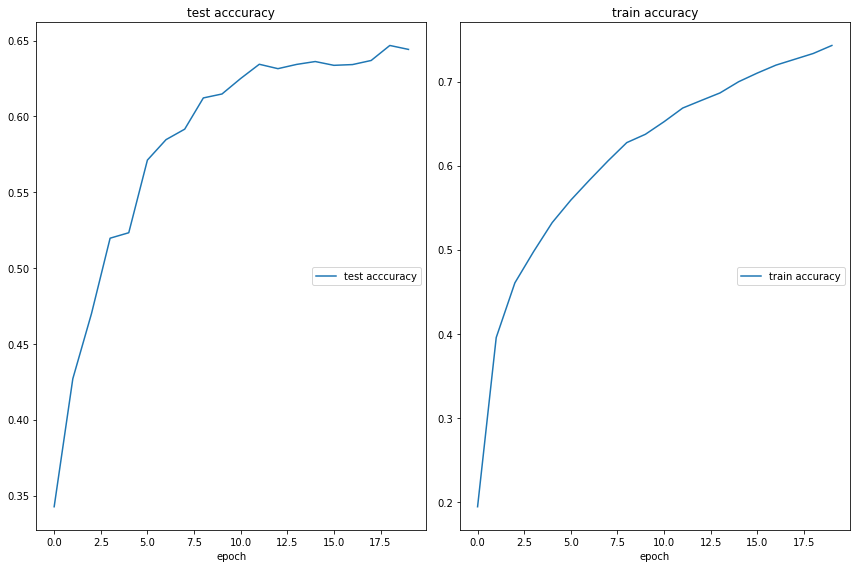

test acccuracy
	test acccuracy   	 (min:    0.343, max:    0.647, cur:    0.644)
train accuracy
	train accuracy   	 (min:    0.194, max:    0.743, cur:    0.743)


In [12]:
# モデルの学習
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

#model = Net_Simple()
model = Net()
#model = Net_Dropout()
#model = Net_BatchNorm()
model.to(device)

learning_rate = 0.01 # 学習率
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # 最適化法
loss_fn = torch.nn.CrossEntropyLoss() # 損失関数

epochs = 20 # エポック数
liveloss = PlotLosses()

for epoch in range(epochs):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    model.train(True) # 訓練モード
    for i, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        # forward
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)

        ## 評価
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_train).float().mean()       
        train_loss.append(loss.item())
        train_acc.append(acc.item())

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval() # 評価モード    
    for i, (X_test, y_test) in enumerate(test_loader):
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # forward
        y_pred = model(X_test) 
        loss = loss_fn(y_pred, y_test) 

        # 評価
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_test).float().mean() 
        test_loss.append(loss.item())
        test_acc.append(acc.item())     

    liveloss.update({
        #'train_loss': np.array(train_loss).mean(),
        #'test_loss': np.array(test_loss).mean(),
        'train accuracy': np.array(train_acc).mean(),
        'test acccuracy': np.array(test_acc).mean()
    })
    liveloss.draw() 

In [13]:
# クラスごとの認識精度
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
          
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 79 %
Accuracy of  bird : 42 %
Accuracy of   cat : 46 %
Accuracy of  deer : 67 %
Accuracy of   dog : 52 %
Accuracy of  frog : 72 %
Accuracy of horse : 72 %
Accuracy of  ship : 77 %
Accuracy of truck : 70 %


## モデル選択・パラメータ最適化

### ネットワークの構成
ネットワークの深さ（畳み込み層+プーリング層の数）やネットワークの幅（畳み込み層のチャンネル数）を変えてみてください

### CNNの代表的なアーキテクチャー
- [AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/)
- [VGG](https://pytorch.org/hub/pytorch_vision_vgg/)
- [GoogLeNet](https://pytorch.org/hub/pytorch_vision_googlenet/)
- [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/)

学習済みモデルを用いた転移学習も可能。
### 活性化関数
活性化関数はまずはReLUを使用するのがよいですが、学習率に留意していください（学習曲線で誤差が減少していくこと確認してください）。その他、Leakly ReLU, Maxout, ELU, SELUなどの活性化関数もあります。

[活性化関数](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions)

### 入力の標準化
入力は標準化しておくとよいです（特に画像の場合は平均のcentering）。最適化が安定します。

### パラメータ初期化
勾配消失（または爆発）を避けるために、特に深いネットワーク構造ではパラメータを適切に初期化（XavierやKaimingの初期化法など）しておくのがよいです

[パラメータ初期化](https://pytorch.org/docs/stable/nn.init.html)

### バッチ正規化
モデルの学習時、バッチごとに各チャンネルを正規化するバッチ正規化を導入する（フルコネクト層や畳み込み層の非線形変換の前で）と学習が安定（勾配流の向上）し、より大きな学習率でパラメータの最適化を早めることができます。
また、パラメータの初期値対して頑健になるとともに正則化の役割も果たします。

### 最適化手法
まずは、SGDとモメンタムの組み合わせかAdamを使用するのがよいです。
SGDでは学習率調整（コサインスケジューラーなど）を導入するのがよいです。

### 過学習の対処
#### Early Stopping
学習曲線をみながら、過学習が起こる前のエポックのパラメータを採用しましょう。
### 正則化
過学習にはL2正則化も有効です。
### ドロップアウト
ネットワークの任意のユニットの活性をランダムに抑制するドロップアウトも過学習に有効です。層間のつながりランダムに切断するドロップコネクトもあります。
### Data Augmentation
過学習の場合は訓練データを増やすことが有効なので、データを拡張する（画像の場合は反転、リサイズ、切り取りなど）ことも有効です。
